# Oza Boosting

Alongside Online Bagging, Oza and Russell introduced an online versions of boosting in [1]. Different to the bagging version, when a member of the ensemble misclassifies a training example, the associated Poisson-distribution is increased when passing it to the next member of the ensemble, otherwise it is decreased.

> [1] Nikunj C. Oza and Stuart Russell. “Online Bagging and Boosting”. In:Eighth International  Workshop  on  Artificial  Intelligence  and  Statistics. Ed. by Tommi Jaakkola and Thomas Richardson. Key West, Florida. USA: Morgan Kaufmann, 2001, pp. 105–112.url:https://ti.arc.nasa.gov/m/profile/oza/files/ozru01a.pdf.1

# Task

In this TP you will implement the Oza Boosting classifier in Python.  You can use as references the Oza Bagging implementation in `scikit-multiflow` and the implementation of the online version in `MOA`.

As in the previous TP, here we provide a template for the classifier.

In [61]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.utils import check_random_state
import math
import copy
import numpy as np

class OzaBoosting:

    def __init__(self, base_estimator=HoeffdingTree(), n_estimators=3, random_state=None):
        # TODO
        '''
        Parameters
        ----------
        base_estimator: StreamModel
            This is the ensemble classifier type, each ensemble classifier is going 
            to be a copy of the base_estimator.

        n_estimators: int
            The size of the ensemble, in other words, how many classifiers to train.

        random_state: int, RandomState instance or None, optional (default=None)
            If int, random_state is the seed used by the random number generator;
            If RandomState instance, random_state is the random number generator;
            If None, the random number generator is the RandomState instance.
        '''
        self.n_estimators=n_estimators
        self.ensemble = [copy.deepcopy(base_estimator) for _ in range(self.n_estimators)]
        self.random_state = check_random_state(random_state)
        self.lamda_sc = [0 for _ in range(self.n_estimators)]
        self.lamda_sw = [0 for _ in range(self.n_estimators)]
        self.epsilon = [0 for _ in range(self.n_estimators)]
        self.pre_train = True
        self.pre_predict = False
        
    def fit(self, X, y=None, classes=None):
        lamda = 1#lamda
        for m in range(self.n_estimators):
            k = self.random_state.poisson(lamda)
            if k > 0:
                for n in range(k):
                    self.ensemble[m].partial_fit(X,y)
            if np.array_equal(self.ensemble[m].predict(X),y):
                self.lamda_sc[m] += lamda
                self.epsilon[m] = self.lamda_sw[m] / (self.lamda_sw[m] + self.lamda_sc[m])
                lamda = lamda * 0.5 / (1 - self.epsilon[m])
            else:
                self.lamda_sw[m] += lamda
                self.epsilon[m] = self.lamda_sw[m] / (self.lamda_sw[m] + self.lamda_sc[m])
                lamda = lamda * 0.5 / self.epsilon[m]
        return self

    def partial_fit(self, X, y=None, classes=None):
        # TODO 
        r,c =X.shape
        if self.pre_train:
            for i in range(r):
                self.fit([X[i].tolist()],[y[i].tolist()])
            self.pre_train=False
        else:
            self.fit(X,y,classes)
        return self

    def predict(self, X):
        # TODO
        r, c = X.shape
        proba = []
        proba_list = []
        tmp = []
        predictions = []
        for n in range(self.n_estimators):
            beta = - math.log(self.epsilon[n] / (1 - self.epsilon[n]))
            partial_proba = self.ensemble[n].predict_proba(X)
            for i in range(r):
                if len(proba) < 1:
                    proba.append([0.0 for _ in partial_proba[i]])
                for j in range(len(partial_proba[i])):
                    proba[i][j] += partial_proba[i][j] * beta         
        for l in range(r):
            proba_list.append(np.sum(proba[l]))
        for i in range(len(proba)):
            if proba_list[i] > 0.:
                tmp.append([x / proba_list[i] for x in proba[i]])
            else:
                tmp.append(proba[i])
        proba = np.asarray(tmp)       
        for i in range(r):
            predictions.append(np.argmax(proba[i]))
        res = np.asarray(predictions)
        return res

## Evaluation

The following piece of code evaluates the three classifiers and gives the online visualization. It computes the current and global values for `accuracy` and `kappa`. Current value of selected evaluation measure represents the performance of the model on the current window and global value represents the performance of the model on whole datastream. `EvaluatePrequential` also gives the summary of evaluation showing the `Evaluation Time`.

<IPython.core.display.Javascript object>


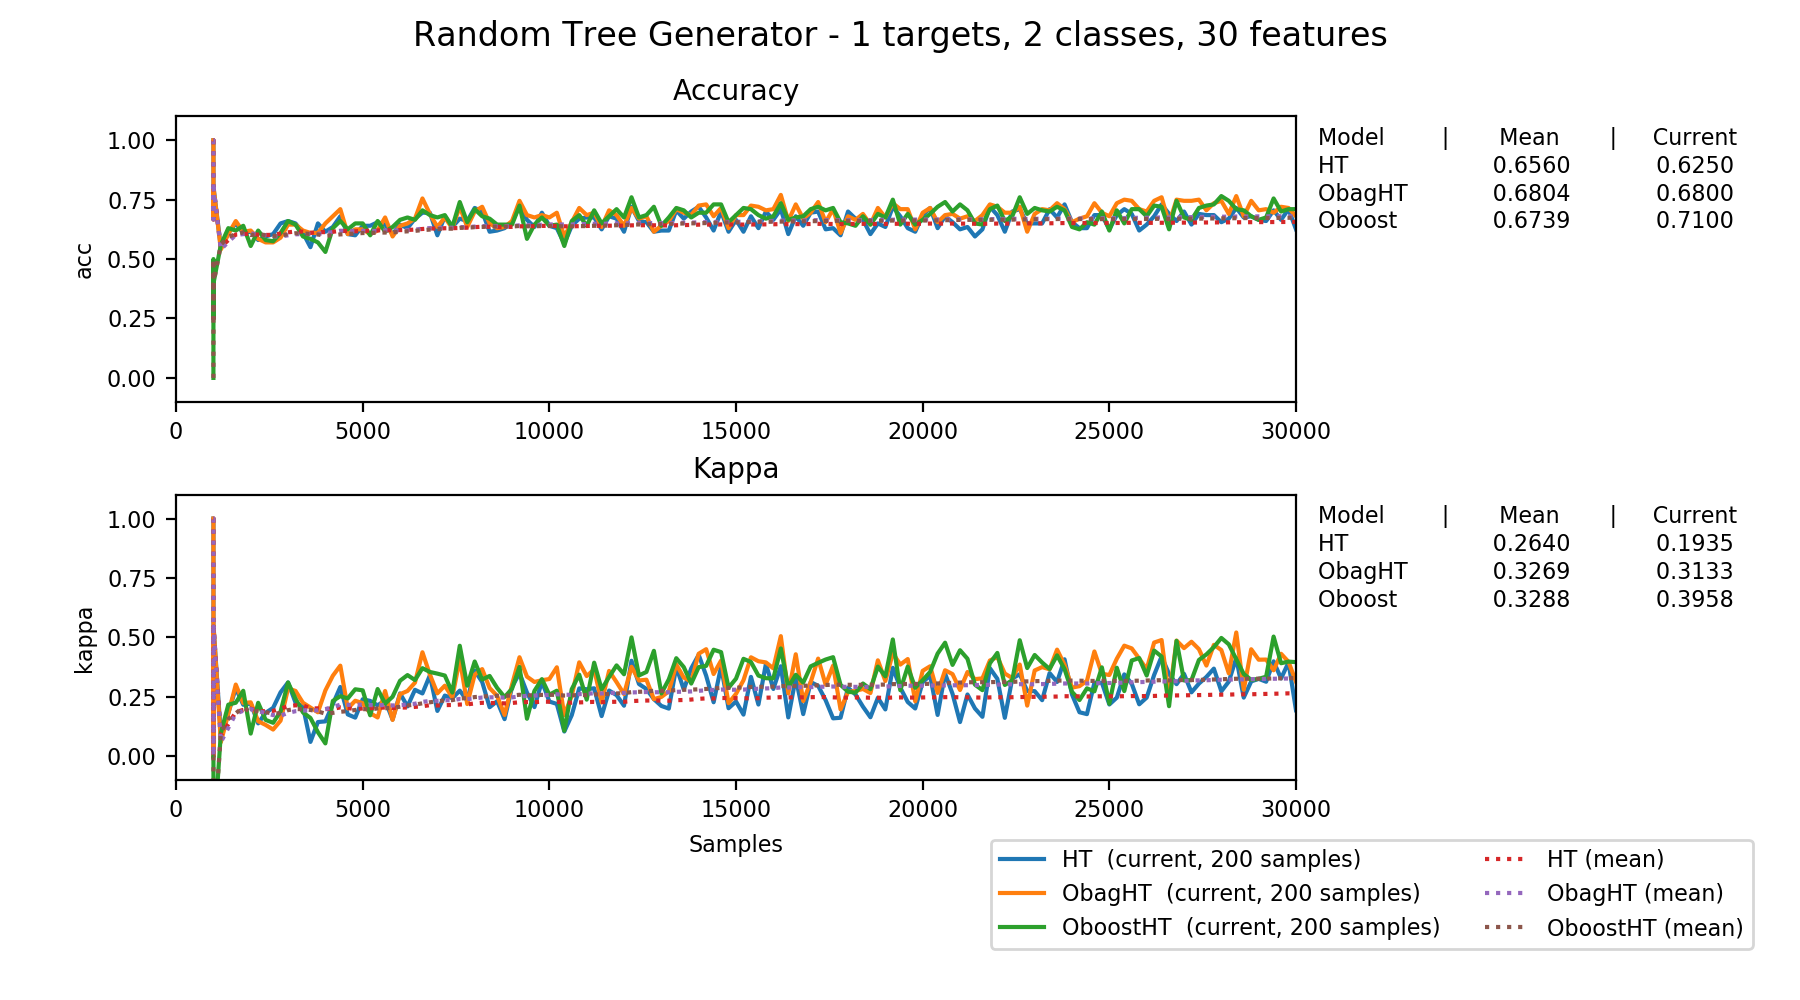

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [136.95s]
Processed samples: 30000
Mean performance:
HT - Accuracy     : 0.6560
HT - Kappa        : 0.2640
ObagHT - Accuracy     : 0.6804
ObagHT - Kappa        : 0.3269
OboostHT - Accuracy     : 0.6739
OboostHT - Kappa        : 0.3288


In [72]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.meta import OzaBagging
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import RandomTreeGenerator
from skmultiflow.trees.hoeffding_adaptive_tree import HAT
import skmultiflow.trees.regression_hoeffding_tree 
import matplotlib as plt

%matplotlib notebook

# 1. Create a stream

stream = RandomTreeGenerator(tree_random_state=0, sample_random_state=0)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [
    HoeffdingTree(),
    OzaBagging(base_estimator=HoeffdingTree(), n_estimators=5, random_state=5),
    OzaBoosting(base_estimator=HoeffdingTree(), n_estimators=3, random_state=None)   # Uncomment when implemented
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, show_plot=True, max_samples=30000,
                                metrics=['accuracy', 'kappa'], batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HT', 'ObagHT','OboostHT'])

<IPython.core.display.Javascript object>


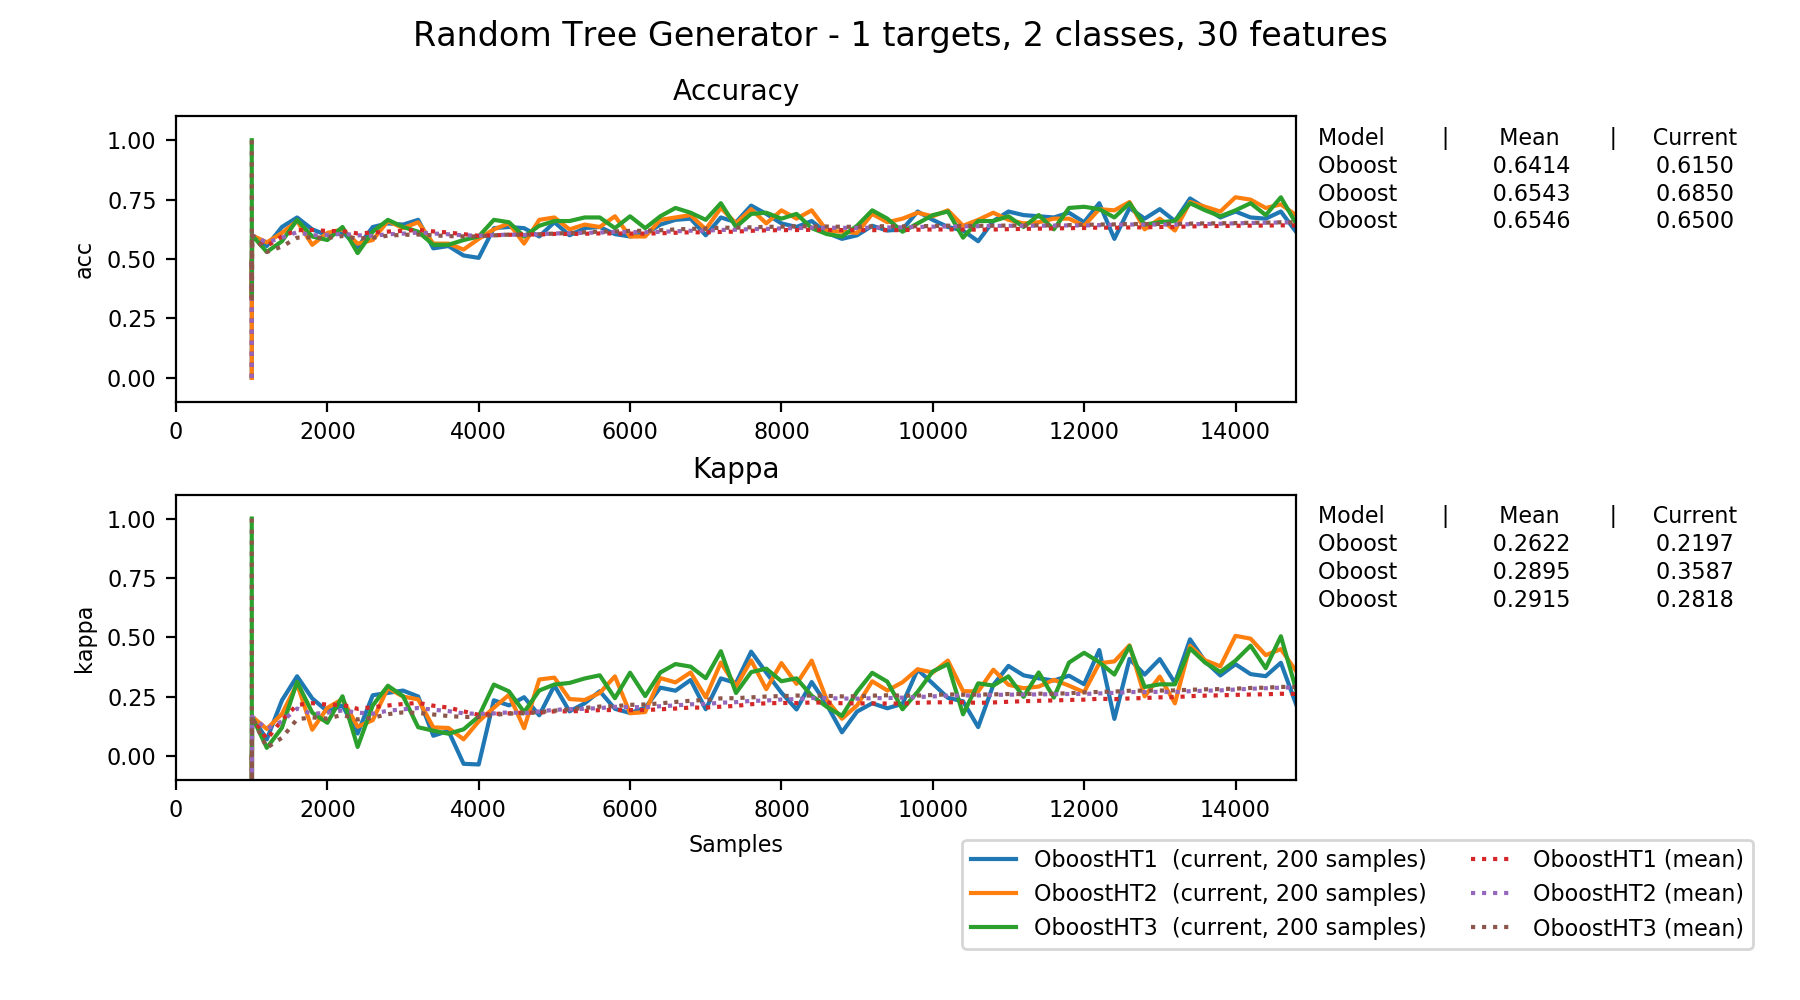

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #########----------- [45%] [127.99s]list index out of range
Processed samples: 14915
Mean performance:
OboostHT1 - Accuracy     : 0.6414
OboostHT1 - Kappa        : 0.2622
OboostHT2 - Accuracy     : 0.6543
OboostHT2 - Kappa        : 0.2895
OboostHT3 - Accuracy     : 0.6546
OboostHT3 - Kappa        : 0.2915


In [74]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.meta import OzaBagging
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import RandomTreeGenerator
from skmultiflow.trees.hoeffding_adaptive_tree import HAT
import skmultiflow.trees.regression_hoeffding_tree 
import matplotlib as plt

%matplotlib notebook

# 1. Create a stream

stream = RandomTreeGenerator(tree_random_state=0, sample_random_state=0)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [
    OzaBoosting(base_estimator=HoeffdingTree(), n_estimators=3, random_state=None),   # Uncomment when implemented
    OzaBoosting(base_estimator=HoeffdingTree(), n_estimators=5, random_state=None),
    OzaBoosting(base_estimator=HoeffdingTree(), n_estimators=7, random_state=None)
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, show_plot=True, max_samples=30000,
                                metrics=['accuracy', 'kappa'], batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['OboostHT1', 'OboostHT2','OboostHT3'])

<IPython.core.display.Javascript object>


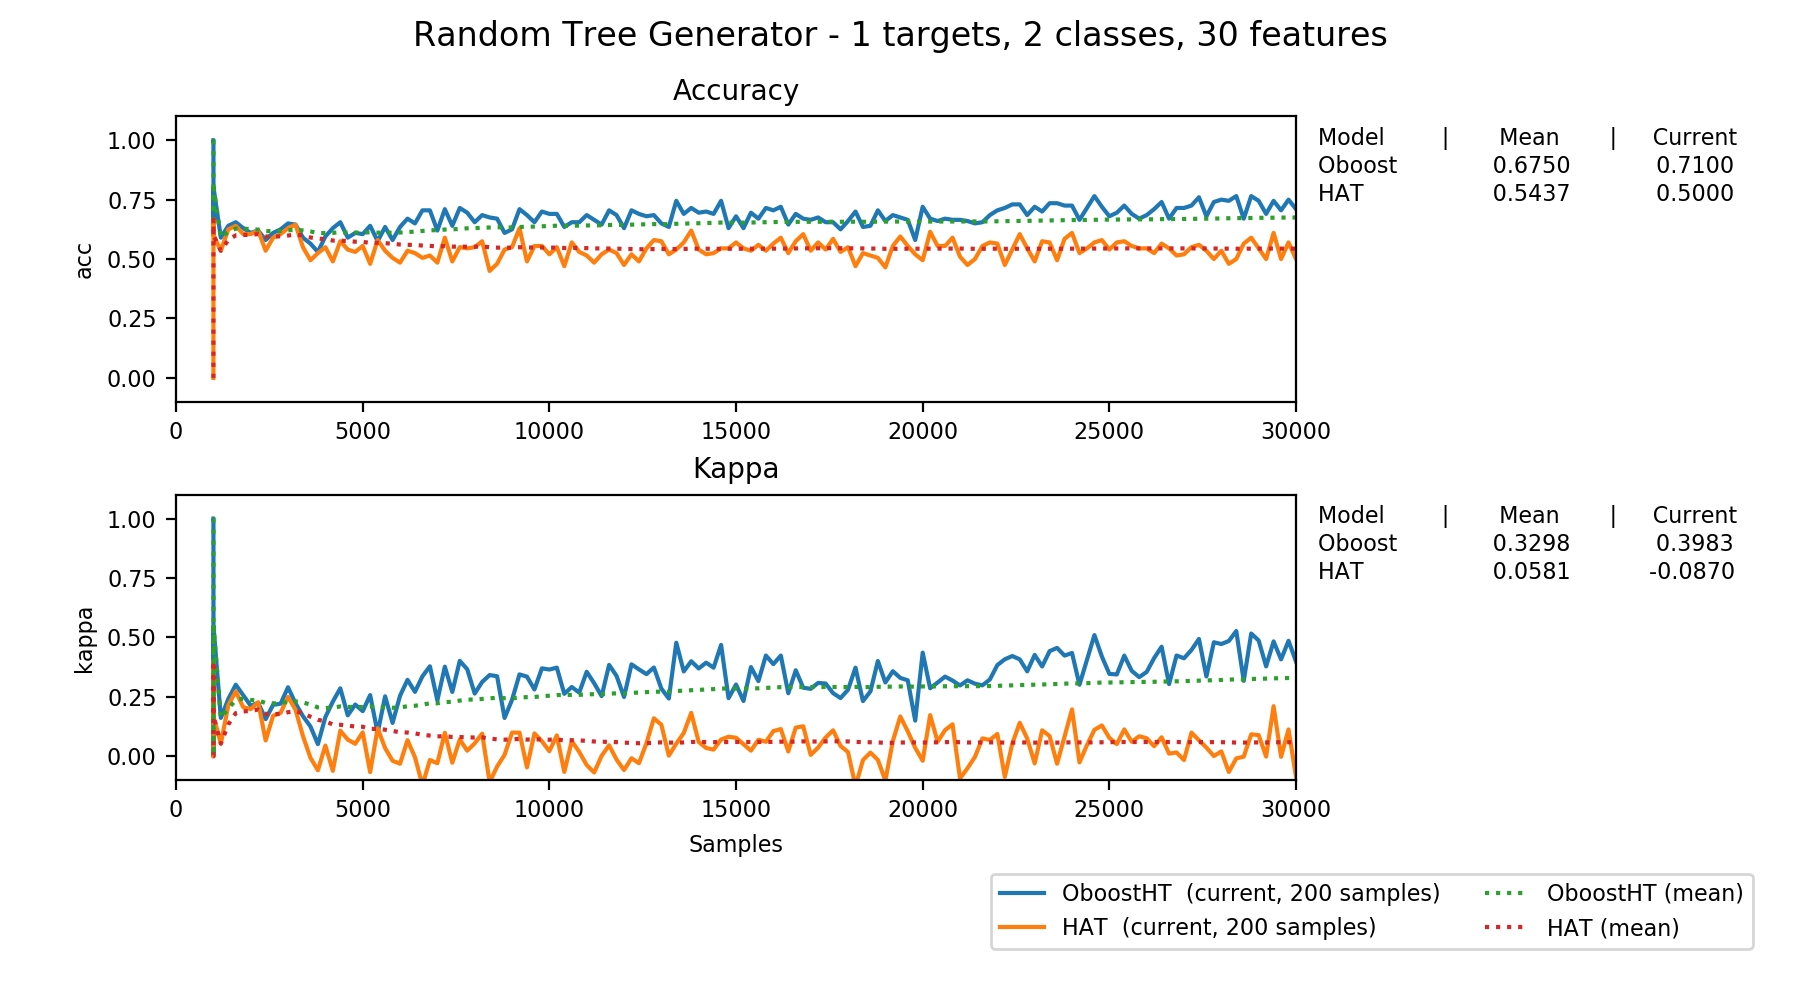

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [116.32s]
Processed samples: 30000
Mean performance:
OboostHT - Accuracy     : 0.6750
OboostHT - Kappa        : 0.3298
HAT - Accuracy     : 0.5437
HAT - Kappa        : 0.0581


In [75]:
from skmultiflow.trees import HoeffdingTree
from skmultiflow.meta import OzaBagging
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import RandomTreeGenerator
from skmultiflow.trees.hoeffding_adaptive_tree import HAT
import skmultiflow.trees.regression_hoeffding_tree 
import matplotlib as plt

%matplotlib notebook

# 1. Create a stream

stream = RandomTreeGenerator(tree_random_state=0, sample_random_state=0)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [
    OzaBoosting(base_estimator=HoeffdingTree(), n_estimators=3, random_state=None),   # Uncomment when implemented
    OzaBoosting(base_estimator=HAT(), n_estimators=3, random_state=None)
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, show_plot=True, max_samples=30000,
                                metrics=['accuracy', 'kappa'], batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['OboostHT', 'HAT'])

## Discussion

In this cell we ask you to write your observations about the Oza Boosting classifier based on your tests. For example, what is the impact of the base estimator and the number of estimators in the ensemble.

(Write your observations here)




From my tests, we could know my implementation of OZABoosting has the mean accuracy of 0.67, it is a little better than a single HoeffdingTree, worse than OZABagging. 
For the base estimator as the parameter, I have test the HoeffdingTree and HoeffdingAdaptiveTree, the result shows that the HoeffdingTree has a better accuracy.
And when we change the number of estimators, we can notice that the accuracy will increase when the number of estimators is bigger.

## Deliverables

You must submit:
1. This Jupyter Notebook (completed) 
2. The `html` version of the notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab3.zip`